In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa
from pyrsa.model import ModelFamily


In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

In [3]:
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

In [4]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')

In [5]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


In [6]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','smooth1rpwavgFeat')
    m = pyrsa.model.ModelFixed(i_model, rdm_m)
    models.append(m)

C:\Users\kshitij\Anaconda3\envs\dnn2brain_fn\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kshitij\Anaconda3\envs\dnn2brain_fn\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [7]:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=4,pattern_descriptor='index')

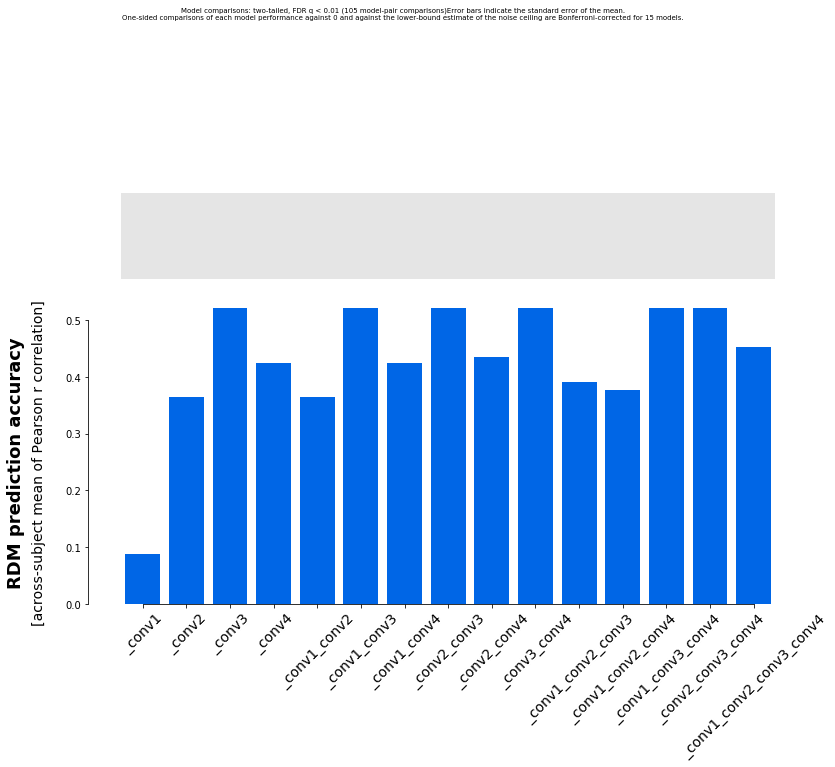

In [8]:
model_family = ModelFamily(models[0:4])
results_3_cv = pyrsa.inference.crossval(model_family.get_all_family_members(), rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_cv)

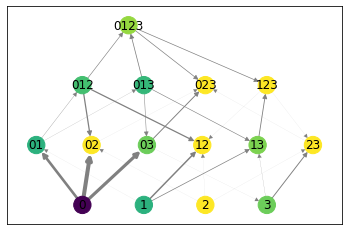

In [9]:
pyrsa.vis.show_family_graph(model_family,results_3_cv)